<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/mnist_confused_logits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=False

Prepare dataset

In [3]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Architecture and training script

In [4]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x



def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        # #Print out the loss periodically. 
        # if batch_idx % args['log_interval'] == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    return test_loss, correct




Train the model

In [5]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test_loss, correct = test()
    print('Test set: Epoch:{}, Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Epoch:1, Average loss: 2.1331, Accuracy: 4984/10000 (50%)
Test set: Epoch:2, Average loss: 1.3770, Accuracy: 7000/10000 (70%)
Test set: Epoch:3, Average loss: 0.7531, Accuracy: 8245/10000 (82%)
Test set: Epoch:4, Average loss: 0.5435, Accuracy: 8654/10000 (87%)
Test set: Epoch:5, Average loss: 0.4313, Accuracy: 8854/10000 (89%)
Test set: Epoch:6, Average loss: 0.3716, Accuracy: 8993/10000 (90%)
Test set: Epoch:7, Average loss: 0.3291, Accuracy: 9089/10000 (91%)
Test set: Epoch:8, Average loss: 0.2949, Accuracy: 9183/10000 (92%)
Test set: Epoch:9, Average loss: 0.2682, Accuracy: 9249/10000 (92%)
Test set: Epoch:10, Average loss: 0.2477, Accuracy: 9292/10000 (93%)


Visualize first 100 samples and correcponding prediction

In [6]:
import numpy as np

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=False, **kwargs)


x, y = next(iter(train_loader))
#x = x.view(x.size(0), -1)
sample = 13
for sample in range(100):
    input = torch.nn.Parameter(x[sample])
    outputs = model(input[None])
    prob = F.softmax(outputs, dim=-1)
    pred = outputs.max(1, keepdim=True)[1]
    print(sample, pred, y[sample],round(prob.max().item(),2), np.round(prob.detach().numpy(),3))
#print(preds,'\n', prob)

0 tensor([[3]]) tensor(5) 0.72 [[0.    0.002 0.    0.716 0.    0.277 0.    0.002 0.002 0.001]]
1 tensor([[0]]) tensor(0) 1.0 [[0.998 0.    0.    0.    0.    0.002 0.    0.    0.    0.   ]]
2 tensor([[4]]) tensor(4) 0.92 [[0.    0.    0.003 0.001 0.923 0.    0.    0.002 0.001 0.07 ]]
3 tensor([[1]]) tensor(1) 0.99 [[0.    0.993 0.004 0.    0.    0.    0.    0.    0.002 0.   ]]
4 tensor([[9]]) tensor(9) 0.85 [[0.    0.    0.    0.    0.13  0.    0.    0.023 0.001 0.846]]
5 tensor([[2]]) tensor(2) 0.65 [[0.003 0.005 0.652 0.133 0.007 0.005 0.001 0.102 0.07  0.025]]
6 tensor([[1]]) tensor(1) 0.98 [[0.    0.978 0.006 0.004 0.    0.001 0.002 0.002 0.007 0.   ]]
7 tensor([[3]]) tensor(3) 1.0 [[0.    0.    0.    0.996 0.    0.002 0.    0.    0.001 0.   ]]
8 tensor([[1]]) tensor(1) 0.97 [[0.    0.974 0.003 0.005 0.001 0.002 0.002 0.004 0.008 0.001]]
9 tensor([[4]]) tensor(4) 0.99 [[0.    0.    0.001 0.    0.994 0.    0.    0.    0.    0.005]]
10 tensor([[3]]) tensor(3) 0.99 [[0.    0.    0.    

Get output for a selected sample:

In [28]:
sample = 22
input = torch.nn.Parameter(x[sample])
outputs = model(input[None])
prob = F.softmax(outputs, dim=-1)
pred = outputs.max(1, keepdim=True)[1]
print(sample, pred, y[sample],round(prob.max().item(),2), np.round(prob.detach().numpy(),3))

22 tensor([[9]]) tensor(9) 0.5 [[0.    0.003 0.006 0.001 0.403 0.001 0.001 0.053 0.027 0.504]]


tensor(-0.2249)


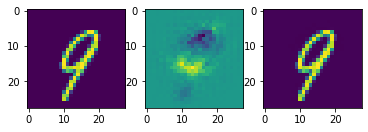

In [27]:
import matplotlib.pyplot as plt
# calculate gradient of 6th output with respect to the input (param)
desire_label_index = 4
label_5_pred = prob[0, desire_label_index]
label_5_pred.backward()

grad_img = input.grad.view(28, 28)
print(grad_img.sum())

plt.subplot(1,3,1)
plt.imshow(input[0].detach().numpy())

plt.subplot(1,3,2)
plt.imshow(grad_img)

plt.subplot(1,3,3)
fused_img = input[0].detach().numpy() + grad_img.detach().numpy()
plt.imshow(fused_img)

Fuse the gradient properly:

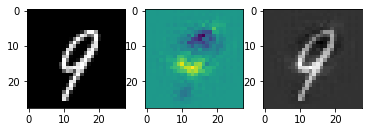

In [22]:
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

plt.subplot(1,3,1)
plt.imshow(input[0].detach().numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.imshow(grad_img)

plt.subplot(1,3,3)
fused_img = NormalizeData(input[0].detach().numpy()) + NormalizeData(grad_img.detach().numpy())
plt.imshow(fused_img, cmap='gray')

Prediction with fused gradient image to get desire prediction:

In [23]:
outputs = model(torch.tensor(fused_img)[None, None])
prob = F.softmax(outputs, dim=-1)
pred = outputs.max(1, keepdim=True)[1]
print(sample, pred, y[sample],round(prob.max().item(),2), np.round(prob.detach().numpy(),3))

22 tensor([[4]]) tensor(9) 0.26 [[0.027 0.035 0.146 0.039 0.258 0.078 0.13  0.023 0.153 0.11 ]]
